## Look at temperature-salinity relationships in Baffin Bay for the boundary condition

In [13]:
import netCDF4 as nc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import matplotlib
import cmocean
from matplotlib.patches import ConnectionPatch
from math import sin, cos, sqrt, atan2, radians
from matplotlib.ticker import MultipleLocator
import gsw

%matplotlib inline

#### Parameters

In [14]:
# domain dimensions:
imin, imax = 1139, 2179
jmin, jmax = 159, 799

# Rimwidths:
rimwidthN  = 10
rimwidthS  = 10
rimwidthW  = 10
rimwidthE  = 20

# Boundary coordinates: (i1,i2,j1,j2)
bdy_BB  = (imin,imin,449,674)   # Baffin Bay

In [15]:
# Colors
land_color = '#a9a7a2'

color_sBB = '#cc0e1d'# '#b0165f'
color_sGR = '#ffb7aa'#'#ff9966'

#### Files

In [16]:
mesh         = nc.Dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mask_Pb-20220317.nc')
mesh_lon     = np.array(mesh.variables['nav_lon'])
mesh_lat     = np.array(mesh.variables['nav_lat'])
mesh_bathy   = np.array(mesh.variables['tmask'][0,:,:,:])
bathy_masked = np.ma.masked_where((mesh_bathy> 0.1), mesh_bathy)
ocean_masked = np.ma.masked_where((mesh_bathy<0.1), mesh_bathy)
depths       = np.array(mesh.variables['nav_lev'])

Boundary Condition file:

In [17]:
# BC = nc.Dataset('/ocean/brogalla/GEOTRACES/data/Pb_OBC-20210302.nc', 'r')
BC     = nc.Dataset('/ocean/brogalla/GEOTRACES/data/Pb_OBC_20220322.nc','r')
dPb_S  = np.array(BC.variables['dPb_S']).reshape(50,10,225)

In [18]:
dPb_S_lons = mesh_lon[bdy_BB[0]:bdy_BB[0]+rimwidthS,bdy_BB[2]:bdy_BB[3]] 
dPb_S_lats = mesh_lat[bdy_BB[0]:bdy_BB[0]+rimwidthS,bdy_BB[2]:bdy_BB[3]]
dPb_S_mdepths = bathy_masked[:,bdy_BB[0]:bdy_BB[0]+rimwidthS,bdy_BB[2]:bdy_BB[3]]

In [19]:
print('Southern boundary dimensions:     ', dPb_S.shape, dPb_S_lons.shape, dPb_S_lats.shape, dPb_S_mdepths.shape)

Southern boundary dimensions:      (50, 10, 225) (10, 225) (10, 225) (50, 10, 225)


Pb observations:

In [20]:
folder= '/ocean/brogalla/GEOTRACES/data/'

# Data from the GEOTRACES 2021 Intermediate Data Product

#------------------------- North Atlantic Ocean:--------------------------------------------------------------
df_NA = nc.Dataset(f'{folder}IDP2021_GEOTRACES_IDP2021_Seawater_Discrete_Sample_Data_v1_pZVh4suO.nc')
NA_lons       = np.array(df_NA.variables['longitude'])
NA_lats       = np.array(df_NA.variables['latitude'])
NA_pressure   = np.array(df_NA.variables['var1']) # pressure from CTD sensor in dbar
NA_depths     = np.array(df_NA.variables['var2']) # depth below sea surface calculated from pressure
NA_temp_C     = np.array(df_NA.variables['var3']) # temperature from CTD sensor in ITS-90 convention
NA_sal_pss78  = np.array(df_NA.variables['var4']) # practical salinity from CTD sensor in PSS-1978 scale
NA_dPb_pmolkg = np.array(df_NA.variables['var9']) # concentration of dissolved Pb in pmol/kg 

#---- unit conversions: ----
# CTD sensor pressure --> sea pressure (absolute pressure minus 10.1325 dbar); mask pressures less than atmospheric pressure
NA_sea_pressure = np.ma.masked_where(NA_pressure < -1e8, NA_pressure)
# practical salinity --> absolute salinity (g/kg)
NA_lons_tile  = np.tile(NA_lons, (301,1)).transpose()
NA_lats_tile  = np.tile(NA_lats, (301,1)).transpose()
NA_sal_abs      = gsw.conversions.SA_from_SP(NA_sal_pss78, NA_sea_pressure, NA_lons_tile, NA_lats_tile)
# calculate density: uses in situ temperature, absolute salinity, sea pressure 
NA_density      = gsw.density.rho_t_exact(NA_sal_abs, NA_temp_C, NA_sea_pressure) # kg/m3
# dPb in pmol/kg --> pmol/L
NA_dPb_pmolL    = np.ma.masked_where(NA_dPb_pmolkg < 0, NA_dPb_pmolkg*NA_density*1e-3)

/home/brogalla/miniconda3/envs/julab/lib/python3.6/site-packages/gsw/_wrapped_ufuncs.py:3071: RuntimeWarning: invalid value encountered in rho_t_exact
  return _gsw_ufuncs.rho_t_exact(SA, t, p)


#### Functions

In [21]:
# Convert lat/lon to distance along transect:
def calc_distance(lats, lons):
    R = 6373.0 # approximate radius of earth in km

    lats_rad = [radians(l) for l in lats]
    lons_rad = [radians(l) for l in lons]

    dlon = [lon_step - lons_rad[0] for lon_step in lons_rad]
    dlat = [lat_step - lats_rad[0] for lat_step in lats_rad]

    distance = np.empty((len(dlon)))
    for i in range(0,len(dlon)):
        a = sin(dlat[i] / 2)**2 + cos(lats_rad[0]) * cos(lats_rad[i]) * sin(dlon[i] / 2)**2
        c = 2 * atan2(sqrt(a), sqrt(1 - a))
        distance[i] = R * c
        
    return distance

In [22]:
def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

In [23]:
# Convert lat/lon to closest point on boundary:
def closest_bdy_point(lats, lons, bdy_lat, bdy_lon):

    bdy_ind = np.empty_like(lats)
    for stn in range(0,len(lats)):
        dist = haversine(lons[stn], lats[stn], bdy_lon, bdy_lat)
        if np.min(dist) > 500:
            bdy_ind[stn] = np.nan
        else:
            bdy_ind[stn] = np.argmin(dist)

    return bdy_ind

In [24]:
def plot_BC(axis, bdy_distance, dPb, bathy, obs_distance, obs_depths, obs_dPb, \
            xlim=(0,500), ylim=(4000, -50), vlim=(0,25), cmap=cmocean.cm.deep_r):    
    axis.invert_yaxis()
    axis.set_ylim([ylim[0], ylim[1]])
    axis.set_xlim([xlim[0], xlim[1]])
    axis.tick_params(axis='both', which='major', labelsize=6)
    
    # plot model boundary condition:
    xx, zz = np.meshgrid(bdy_distance, depths)
    CB = axis.pcolormesh(xx, zz, dPb*1e12, vmin=vlim[0], vmax=vlim[1], cmap=cmap)
    axis.pcolormesh(xx, zz, bathy, cmap=matplotlib.colors.ListedColormap([land_color]))
        
    # superimpose observations:
    try:
        axis.scatter(obs_distance, obs_depths, c=obs_dPb, vmin=vlim[0], vmax=vlim[1], edgecolor='w', \
                     cmap=cmap, s=15, linewidth=0.2)
    except:
        pass

    return CB

#### Calculations

In [25]:
# Look at only one slice of the rimwidth thickness boundary:
S_distance  = calc_distance(dPb_S_lats[-1,:]   , dPb_S_lons[-1,:])

In [26]:
# Find index along boundary of the observations
BB_bdy_ind  = closest_bdy_point(NA_lats, NA_lons, dPb_S_lats[-1,:], dPb_S_lons[-1,:])
    
# North Atlantic obs
BB_obs_distance = np.empty(NA_lons.shape); BB_obs_distance[:]=np.nan;
for ind_n in range(0,len(NA_lons)):
    if np.isnan(BB_bdy_ind[ind_n]):
        BB_obs_distance[ind_n] = np.nan
    else:
        BB_obs_distance[ind_n] = S_distance[int(BB_bdy_ind[ind_n])]

#### Labrador Sea boundary

Show T-S cross section to check the extent of the west greenland current. Chose to compare with 2014 since that is the year of the GA01 cruis of the North Atlantic.

In [27]:
# load year 2015 climatology of ANHA12 gridT file:
df_gridT = nc.Dataset('/data/brogalla/ANHA12/gridT_2015_climatology_08.nc')

bdy_temp = np.array(df_gridT.variables['votemper'])[0,:,bdy_BB[0]:bdy_BB[0]+rimwidthS,bdy_BB[2]:bdy_BB[3]]
bdy_sal  = np.array(df_gridT.variables['vosaline'])[0,:,bdy_BB[0]:bdy_BB[0]+rimwidthS,bdy_BB[2]:bdy_BB[3]]

In [28]:
bdy_dens = gsw.density.sigma0(bdy_sal, bdy_temp)

In [29]:
print(np.amax(bdy_dens), np.amin(bdy_dens), np.average(bdy_dens))

27.74579185305015 -0.15651740156806682 17.256350945791144


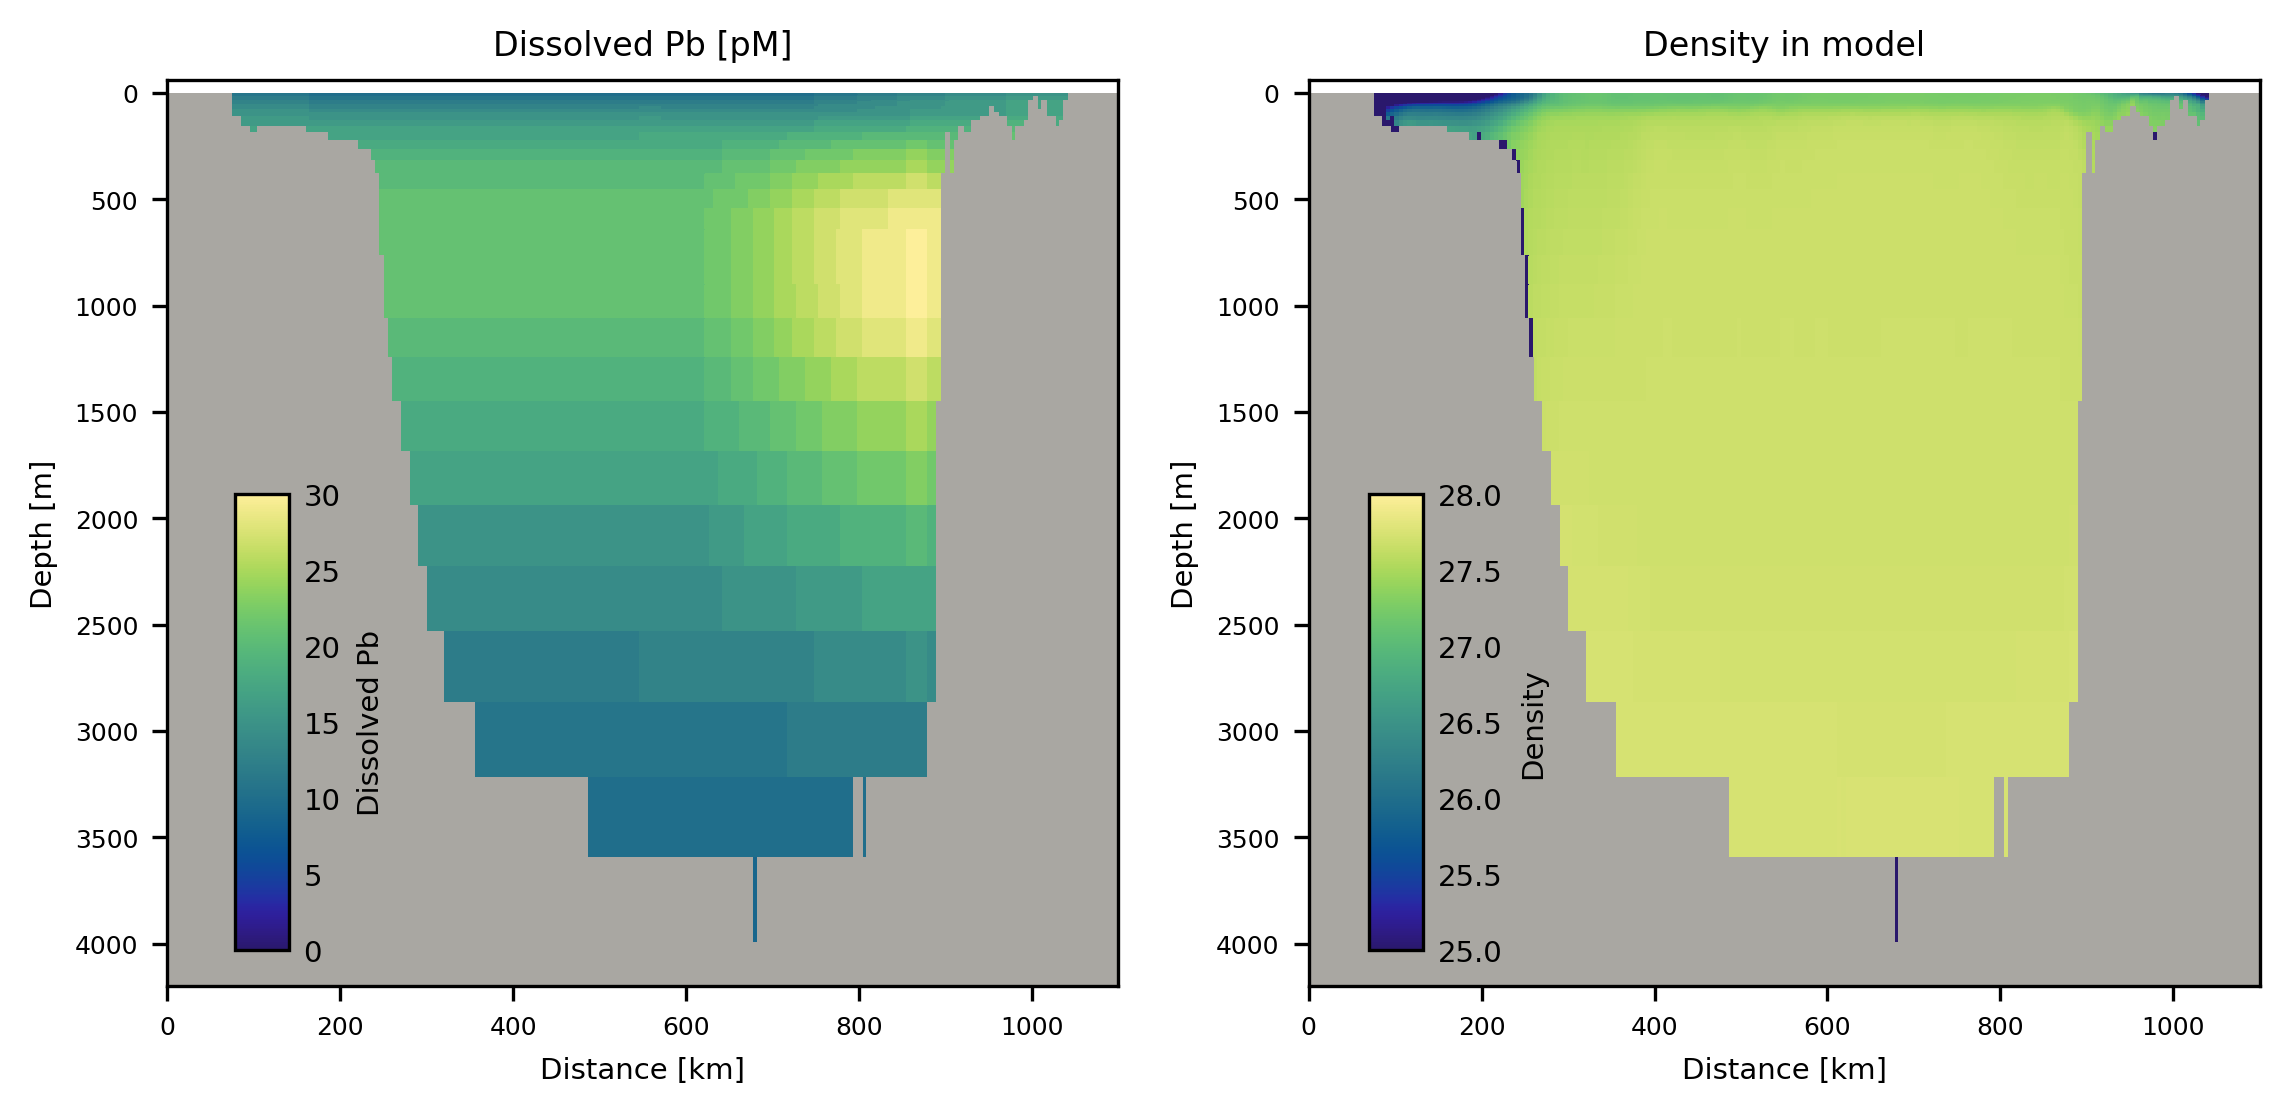

In [80]:
fig, ax = plt.subplots(1,2, figsize=(9, 4), dpi=300)

for axis in ax.ravel():
    axis.invert_yaxis()
    axis.set_ylim(4200, -60)
    axis.set_xlim(0, 1100)
    axis.tick_params(axis='both', which='major', labelsize=6)
    axis.set_xlabel('Distance [km]', fontsize=7)
    axis.set_ylabel('Depth [m]', fontsize=7)
    
ax[0].set_title('Dissolved Pb [pM]', fontsize=8)
ax[1].set_title('Density in model', fontsize=8)

# plot model boundary condition:
xx, zz = np.meshgrid(S_distance, depths)
CB1 = ax[0].pcolormesh(xx, zz, dPb_S[:,-1,:]*1e12, vmin=0, vmax=30, cmap=cmocean.cm.haline)
ax[0].pcolormesh(xx, zz, dPb_S_mdepths[:,-1,:], cmap=matplotlib.colors.ListedColormap([land_color]))

# plot T, S for model
xx, zz = np.meshgrid(S_distance, depths)
CB2 = ax[1].pcolormesh(xx, zz, bdy_dens[8,:,0,:], vmin=25, vmax=28, cmap=cmocean.cm.haline)
ax[1].pcolormesh(xx, zz, dPb_S_mdepths[:,-1,:], cmap=matplotlib.colors.ListedColormap([land_color]))

cbaxes = fig.add_axes([0.15, 0.155, 0.02, 0.38]);
CBar   = plt.colorbar(CB1, ax=ax[1], cax=cbaxes); 
CBar.set_label('Dissolved Pb', fontsize=7)
CBar.ax.tick_params(axis='y', length=0, labelsize=7)

cbaxes = fig.add_axes([0.57, 0.155, 0.02, 0.38]);
CBar   = plt.colorbar(CB2, ax=ax[1], cax=cbaxes); 
CBar.set_label('Density', fontsize=7)
CBar.ax.tick_params(axis='y', length=0, labelsize=7)

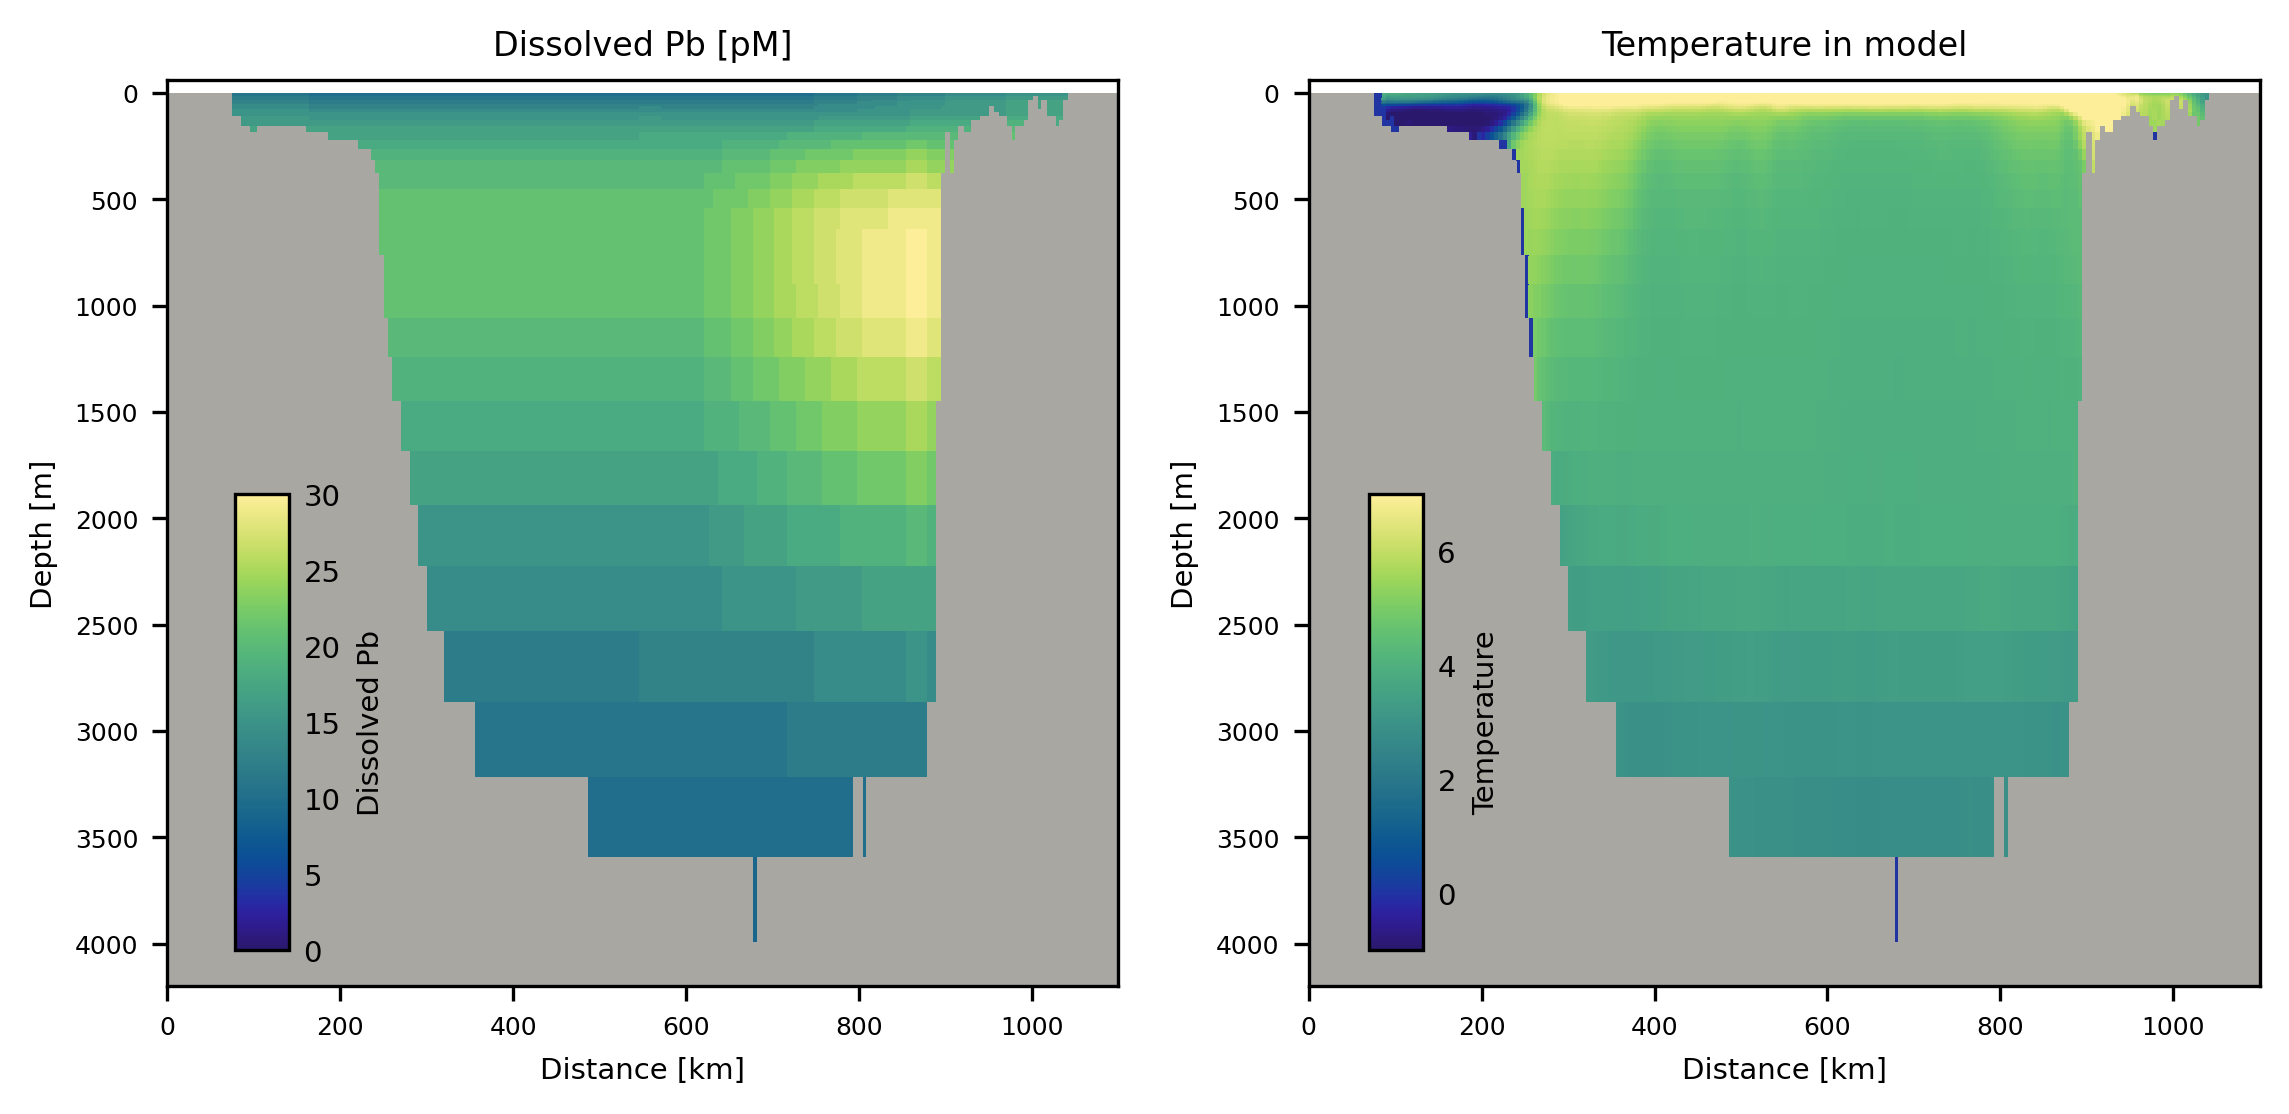

In [81]:
fig, ax = plt.subplots(1,2, figsize=(9, 4), dpi=300)

for axis in ax.ravel():
    axis.invert_yaxis()
    axis.set_ylim(4200, -60)
    axis.set_xlim(0, 1100)
    axis.tick_params(axis='both', which='major', labelsize=6)
    axis.set_xlabel('Distance [km]', fontsize=7)
    axis.set_ylabel('Depth [m]', fontsize=7)
    
ax[0].set_title('Dissolved Pb [pM]', fontsize=8)
ax[1].set_title('Temperature in model', fontsize=8)

# plot model boundary condition:
xx, zz = np.meshgrid(S_distance, depths)
CB1 = ax[0].pcolormesh(xx, zz, dPb_S[:,-1,:]*1e12, vmin=0, vmax=30, cmap=cmocean.cm.haline)
ax[0].pcolormesh(xx, zz, dPb_S_mdepths[:,-1,:], cmap=matplotlib.colors.ListedColormap([land_color]))

# plot T, S for model
xx, zz = np.meshgrid(S_distance, depths)
CB2 = ax[1].pcolormesh(xx, zz, bdy_temp[8,:,0,:], vmin=-1, vmax=7, cmap=cmocean.cm.haline)
ax[1].pcolormesh(xx, zz, dPb_S_mdepths[:,-1,:], cmap=matplotlib.colors.ListedColormap([land_color]))

cbaxes = fig.add_axes([0.15, 0.155, 0.02, 0.38]);
CBar   = plt.colorbar(CB1, ax=ax[1], cax=cbaxes); 
CBar.set_label('Dissolved Pb', fontsize=7)
CBar.ax.tick_params(axis='y', length=0, labelsize=7)

cbaxes = fig.add_axes([0.57, 0.155, 0.02, 0.38]);
CBar   = plt.colorbar(CB2, ax=ax[1], cax=cbaxes); 
CBar.set_label('Temperature', fontsize=7)
CBar.ax.tick_params(axis='y', length=0, labelsize=7)

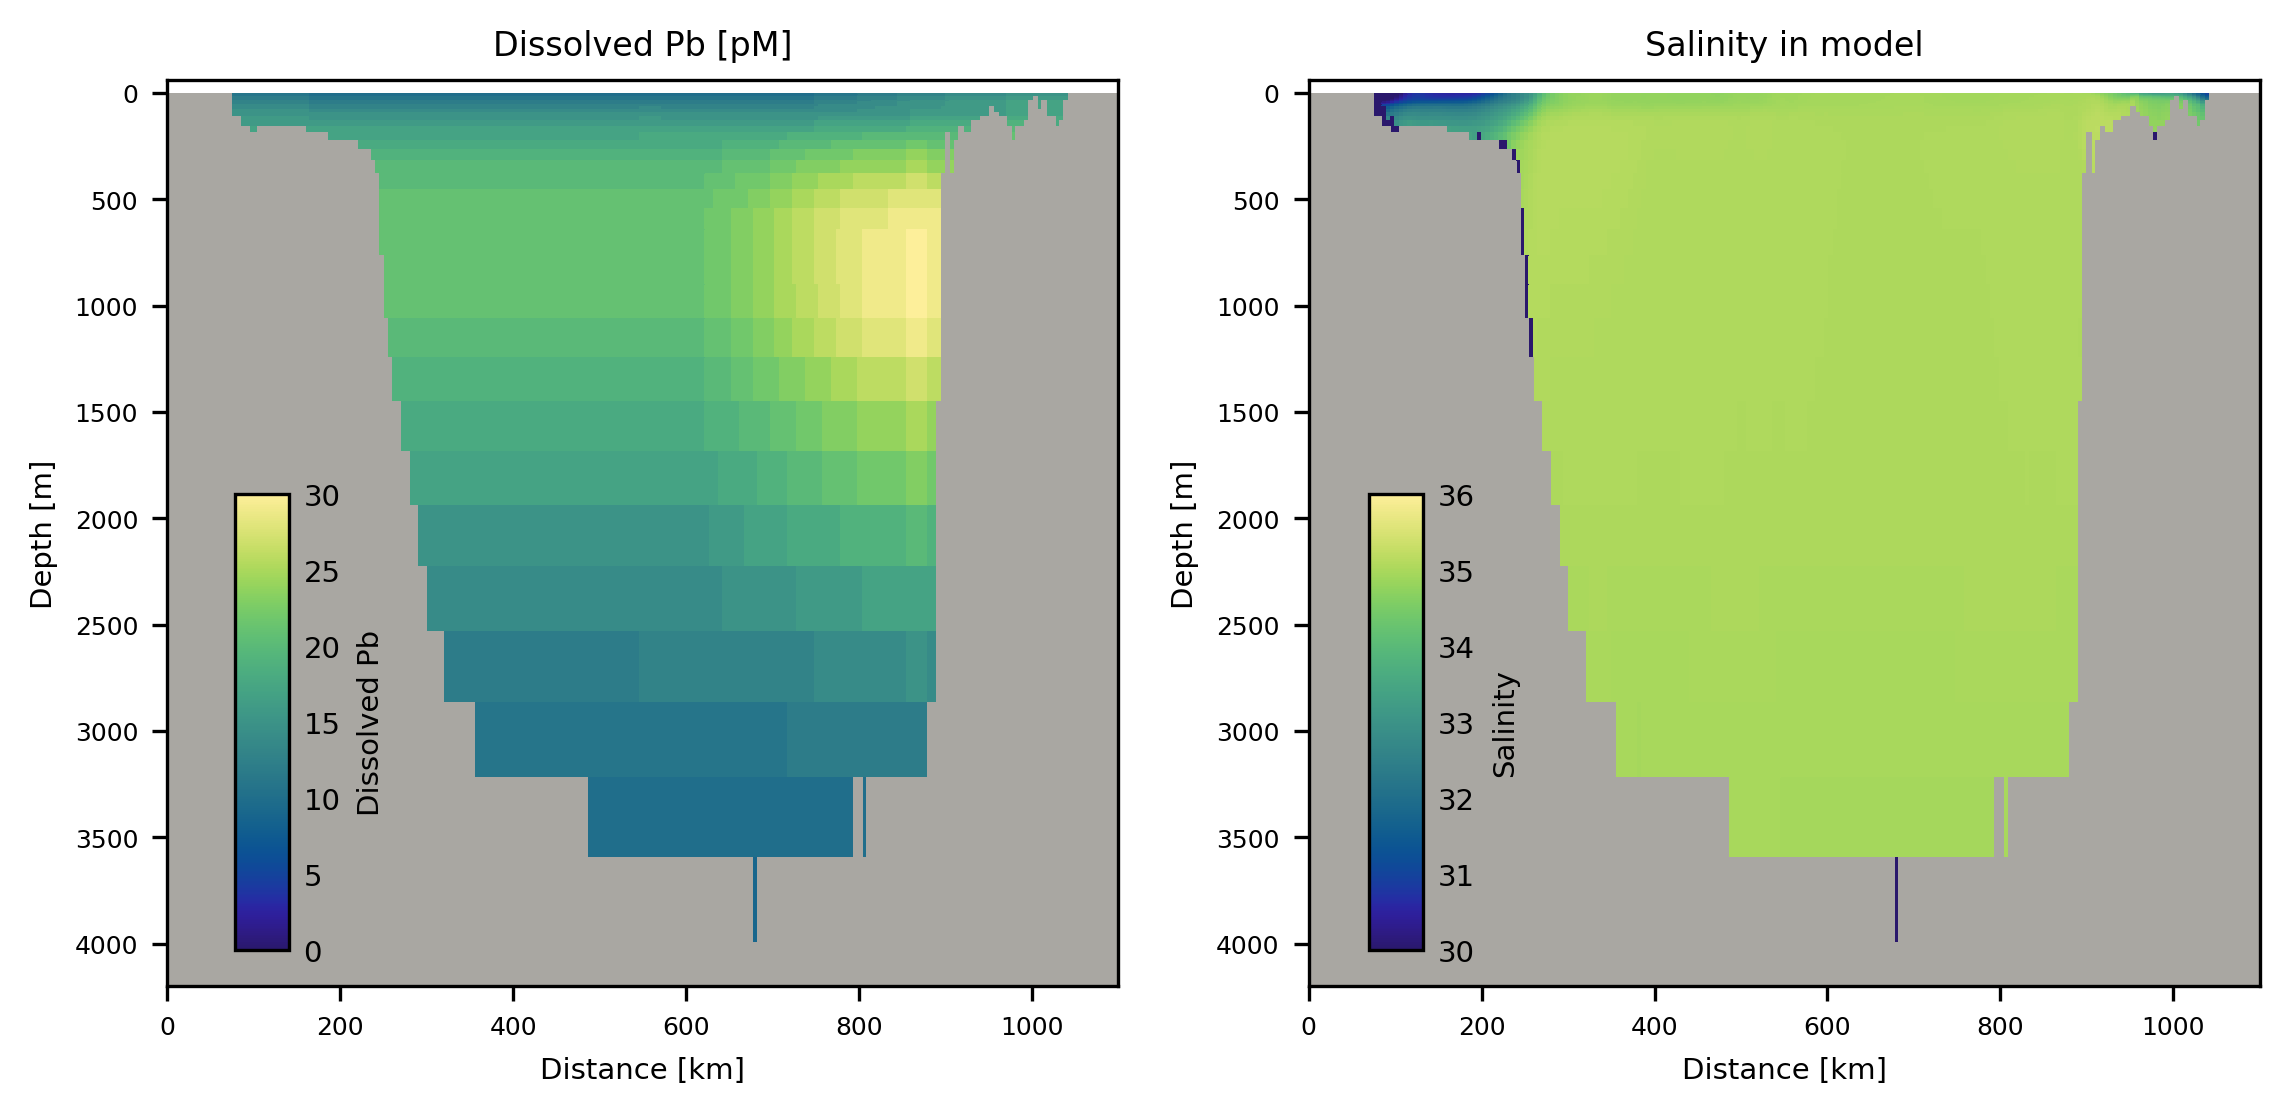

In [82]:
fig, ax = plt.subplots(1,2, figsize=(9, 4), dpi=300)

for axis in ax.ravel():
    axis.invert_yaxis()
    axis.set_ylim(4200, -60)
    axis.set_xlim(0, 1100)
    axis.tick_params(axis='both', which='major', labelsize=6)
    axis.set_xlabel('Distance [km]', fontsize=7)
    axis.set_ylabel('Depth [m]', fontsize=7)
    
ax[0].set_title('Dissolved Pb [pM]', fontsize=8)
ax[1].set_title('Salinity in model', fontsize=8)

# plot model boundary condition:
xx, zz = np.meshgrid(S_distance, depths)
CB1 = ax[0].pcolormesh(xx, zz, dPb_S[:,-1,:]*1e12, vmin=0, vmax=30, cmap=cmocean.cm.haline)
ax[0].pcolormesh(xx, zz, dPb_S_mdepths[:,-1,:], cmap=matplotlib.colors.ListedColormap([land_color]))

# plot T, S for model
xx, zz = np.meshgrid(S_distance, depths)
CB2 = ax[1].pcolormesh(xx, zz, bdy_sal[8,:,0,:], vmin=30, vmax=36, cmap=cmocean.cm.haline)
ax[1].pcolormesh(xx, zz, dPb_S_mdepths[:,-1,:], cmap=matplotlib.colors.ListedColormap([land_color]))

cbaxes = fig.add_axes([0.15, 0.155, 0.02, 0.38]);
CBar   = plt.colorbar(CB1, ax=ax[1], cax=cbaxes); 
CBar.set_label('Dissolved Pb', fontsize=7)
CBar.ax.tick_params(axis='y', length=0, labelsize=7)

cbaxes = fig.add_axes([0.57, 0.155, 0.02, 0.38]);
CBar   = plt.colorbar(CB2, ax=ax[1], cax=cbaxes); 
CBar.set_label('Salinity', fontsize=7)
CBar.ax.tick_params(axis='y', length=0, labelsize=7)

![](forcing/sp-2019-00083a_0004.jpeg)

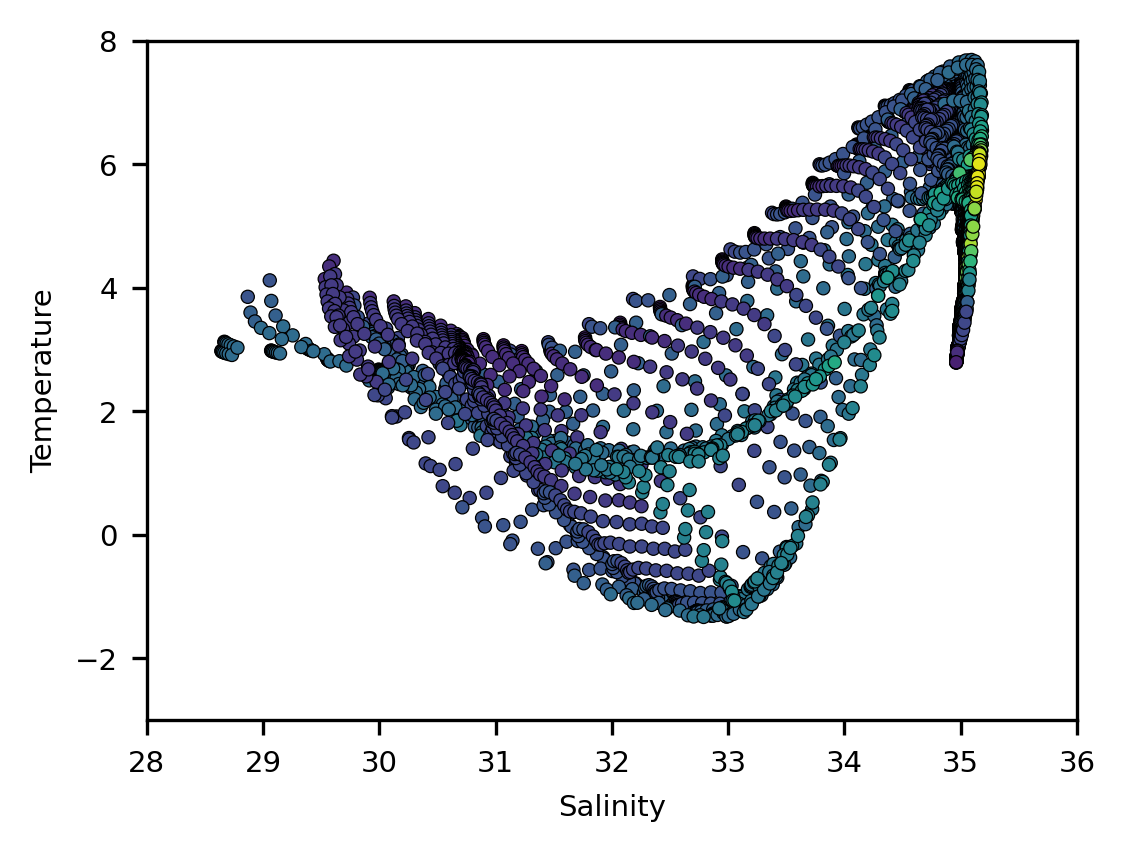

In [23]:
fig, ax = plt.subplots(1,1, figsize=(4,3), dpi=300)

ax.scatter(bdy_sal[:,-1,:], bdy_temp[:,-1,:], c=dPb_S[:,-1,:], s=10, edgecolor='k', linewidth=0.3)

ax.set_xlim(28, 36)
ax.set_ylim(-3, 8)
ax.set_xlabel('Salinity', fontsize=7)
ax.set_ylabel('Temperature', fontsize=7)
ax.tick_params(axis='both', labelsize=7)

#### Create new boundary condition starting from T-S diagram:

In [43]:
dPb_S_new = np.copy(dPb_S)*0.7
# dPb_S_new[dPb_S > 1.5e-11] = 1.5e-11
dPb_S_new[(bdy_sal > 34.8) & (bdy_temp < 4.5)] = 3e-12
# dPb_S_new[(bdy_sal > 34.0) & (bdy_temp > 5.5)] = 2e-11
dPb_S_new[(bdy_sal > 34.3) & (bdy_temp > 7.0)] = 3e-11

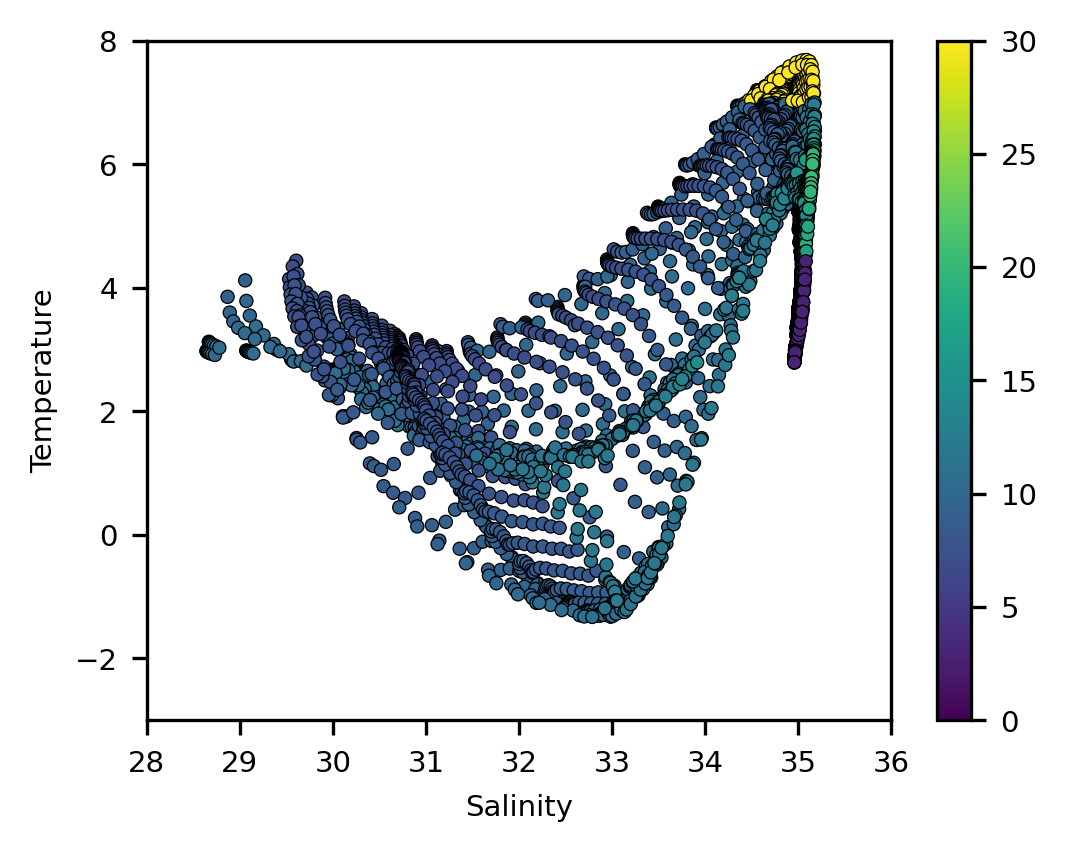

In [44]:
fig, ax = plt.subplots(1,1, figsize=(4,3), dpi=300)

CB = ax.scatter(bdy_sal[:,-1,:], bdy_temp[:,-1,:], c=dPb_S_new[:,-1,:]*1e12, \
                vmin=0, vmax=30, s=10, edgecolor='k', linewidth=0.3)

ax.set_xlim(28, 36)
ax.set_ylim(-3, 8)
ax.set_xlabel('Salinity', fontsize=7)
ax.set_ylabel('Temperature', fontsize=7)
ax.tick_params(axis='both', labelsize=7)

CBar1 = plt.colorbar(CB)
CBar1.ax.tick_params(labelsize=7) 

In [39]:
dPb_S_lons = mesh_lon[bdy_BB[0]:bdy_BB[0]+rimwidthS,bdy_BB[2]:bdy_BB[3]] 
dPb_S_lats = mesh_lat[bdy_BB[0]:bdy_BB[0]+rimwidthS,bdy_BB[2]:bdy_BB[3]]

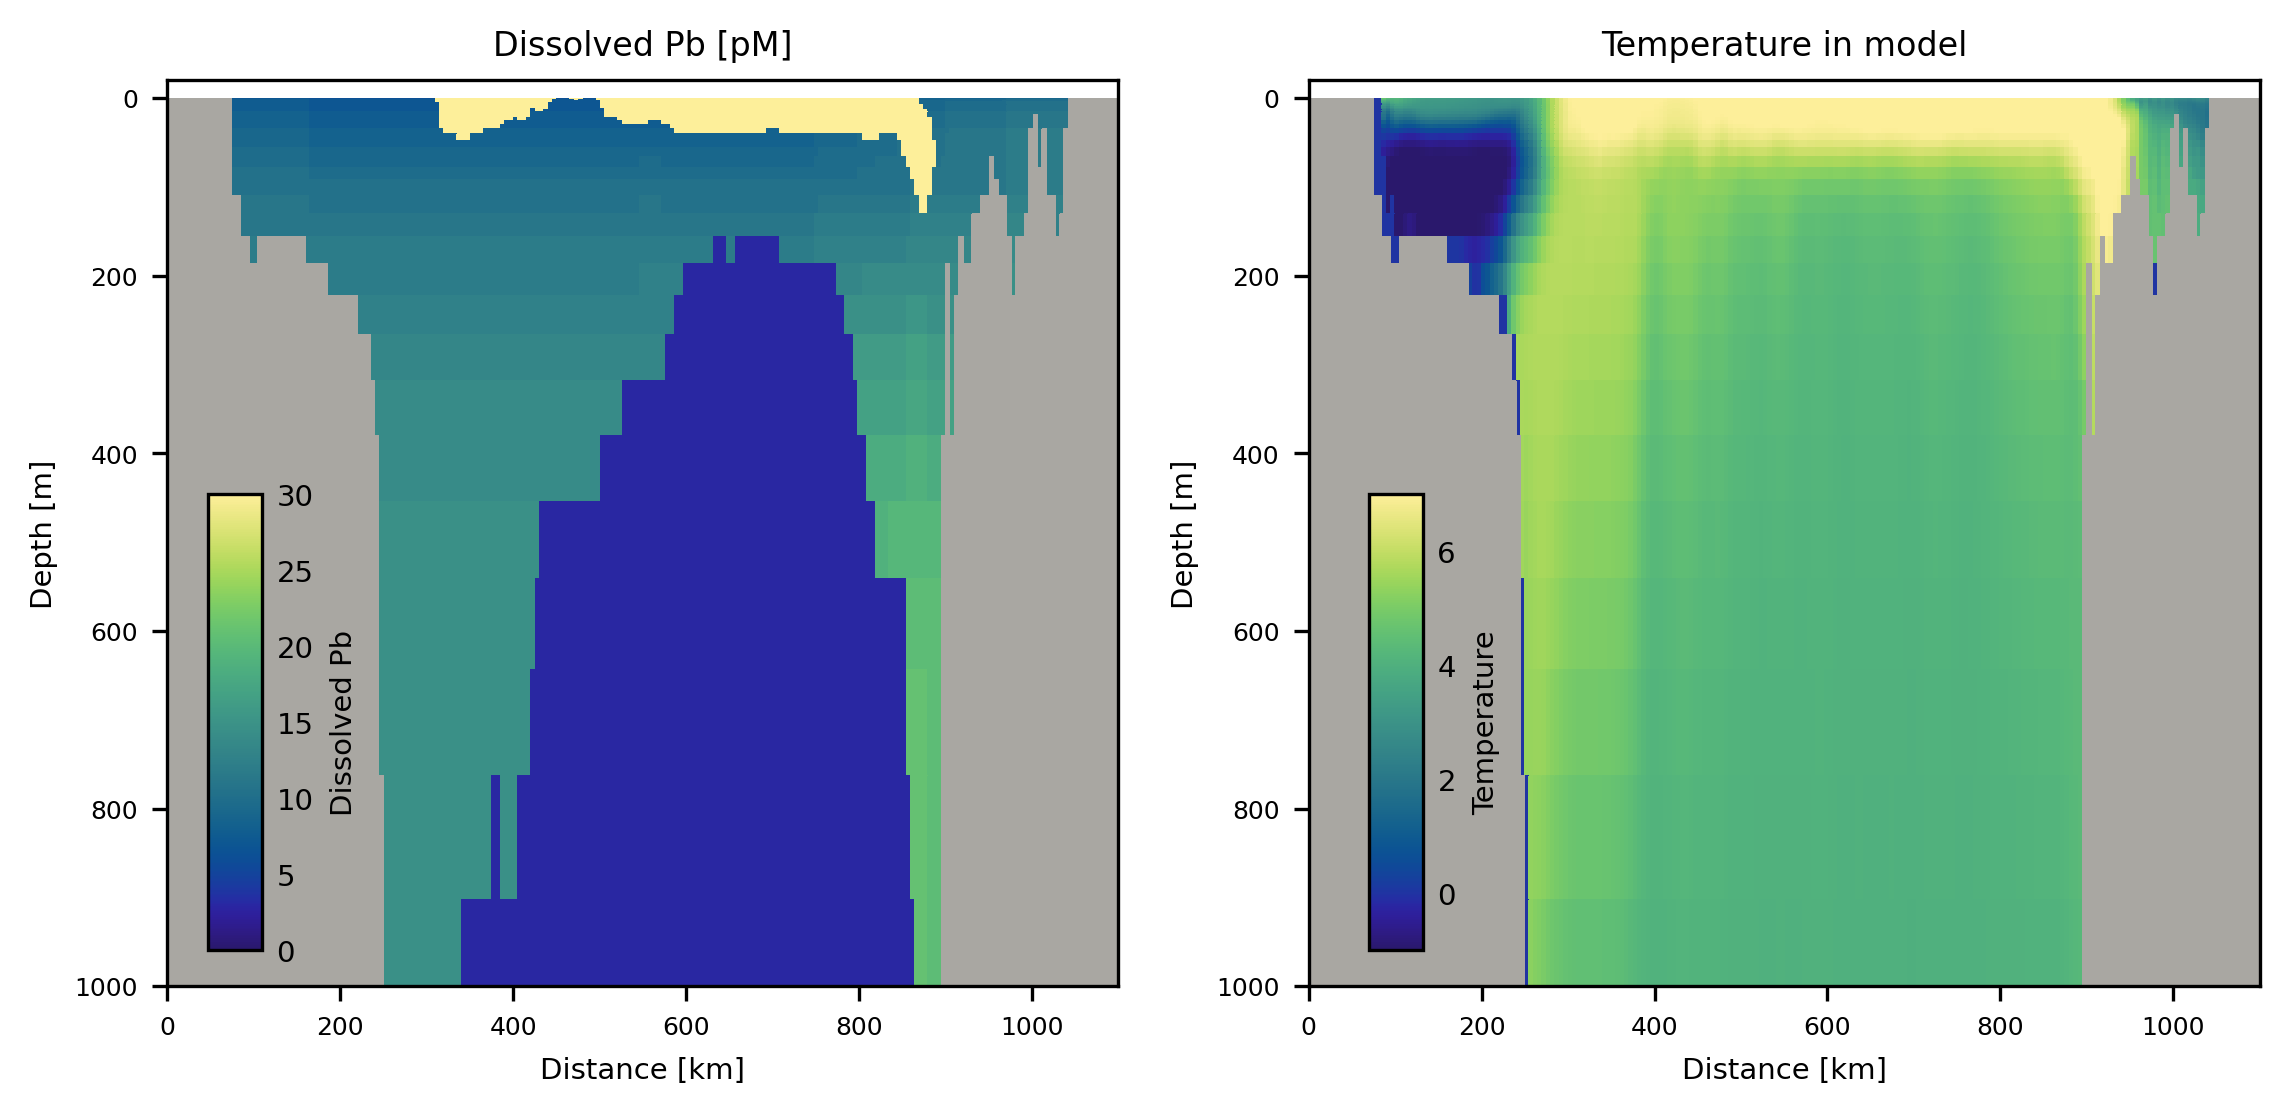

In [47]:
fig, ax = plt.subplots(1,2, figsize=(9, 4), dpi=300)

for axis in ax.ravel():
    axis.invert_yaxis()
    axis.set_ylim(1000, -20)
    axis.set_xlim(0, 1100)
    axis.tick_params(axis='both', which='major', labelsize=6)
    axis.set_xlabel('Distance [km]', fontsize=7)
    axis.set_ylabel('Depth [m]', fontsize=7)
    
ax[0].set_title('Dissolved Pb [pM]', fontsize=8)
ax[1].set_title('Temperature in model', fontsize=8)

# plot model boundary condition:
xx, zz = np.meshgrid(S_distance, depths)
CB1 = ax[0].pcolormesh(xx, zz, dPb_S_new[:,-1,:]*1e12, vmin=0, vmax=30, cmap=cmocean.cm.haline)
ax[0].pcolormesh(xx, zz, dPb_S_mdepths[:,-1,:], cmap=matplotlib.colors.ListedColormap([land_color]))

# plot T, S for model
xx, zz = np.meshgrid(S_distance, depths)
CB2 = ax[1].pcolormesh(xx, zz, bdy_temp[:,0,:], vmin=-1, vmax=7, cmap=cmocean.cm.haline)
ax[1].pcolormesh(xx, zz, dPb_S_mdepths[:,-1,:], cmap=matplotlib.colors.ListedColormap([land_color]))

cbaxes = fig.add_axes([0.14, 0.155, 0.02, 0.38]);
CBar   = plt.colorbar(CB1, ax=ax[1], cax=cbaxes); 
CBar.set_label('Dissolved Pb', fontsize=7)
CBar.ax.tick_params(axis='y', length=0, labelsize=7)

cbaxes = fig.add_axes([0.57, 0.155, 0.02, 0.38]);
CBar   = plt.colorbar(CB2, ax=ax[1], cax=cbaxes); 
CBar.set_label('Temperature', fontsize=7)
CBar.ax.tick_params(axis='y', length=0, labelsize=7)